# 一种划分patch的策略
- 用25个点的像素值取代替一个点像素值，这样会丢失数据的信息

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import numpy as np
from tensorflow.keras import datasets, layers, optimizers, Sequential, metrics
%matplotlib inline

- tensorflow中添加每一层的命令都是大写的
- conv kernel 的数量是以 2 的 n 次方的形式递增的
- 通过 pooling 池化层，相同大小的卷积核覆盖的区域将变大，这是pooling的重要意义

In [2]:

""" 
我拥有的数据集
Indian_pines_corrected.mat   ----   Indian_pines_gt.mat
paviaU.mat   ---   paviaU_gt.mat 
Salinas_corrected.mat   ---   Salinas_gt.mat
Houston.mat   ---   Houston_GT.mat


 """
#  load the Indian pines dataset which is the .mat format
def load_HSI_Data():
    data_path = os.path.join(r'E:\Eric_HSI\hyperspectral_datasets')
    data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))
    labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))
    return data, labels

X, y = load_HSI_Data()

# 打印keys
print(X.keys())
print(y.keys())

# 将dict to ndarray
def dict_to_array(X, y):
    data = X[list(X)[-1]]
    labels = y[list(y)[-1]]
    return data, labels

data, data_gt = dict_to_array(X, y)

dict_keys(['__header__', '__version__', '__globals__', 'salinas_corrected'])
dict_keys(['__header__', '__version__', '__globals__', 'salinas_gt'])


In [3]:
print(data.shape)   #(512, 217, 204) = 22,665,216; 512*217=111,104
print(data_gt.shape)

(512, 217, 204)
(512, 217)


In [4]:
# 归一化，这个归一化的方法有点不一样
data = data -float(np.min(data))
data = data/np.max(data)

In [5]:
# 原始数据转化为X_data 为 (4205, 5, 5, 204) # 21,445,500; 4386*25=109,650
X_data = []
step = 5
x = range(0, 510, step)
y = range(0, 215, step)
for i in x:
  for j in y:
    X_data.append(data[i:i+step, j:j+step])
print(len(X_data))
# print(X_data[0])
# print(X_data[0][0])
# print(len(X_data[0][0][0]))
X_data = np.array(X_data)[:4205]

print(X_data.shape)

4386
(4205, 5, 5, 204)


In [6]:
# 学习使用scipy.stats.mode
#  from scipy.stats import mode
from scipy.stats import mode
a = np.array([[2, 2, 2, 1],
              [1, 2, 2, 2],
              [1, 1, 3, 3]])
print("# Print mode(a):", mode(a))
print("# Print mode(a.transpose()):", mode(a.transpose()))
print("# a的每一列中最常见的成员为：{}，分别出现了{}次。".format(mode(a)[0][0], mode(a)[1][0]))
print("# a的第一列中最常见的成员为：{}，出现了{}次。".format(mode(a)[0][0][0], mode(a)[1][0][0]))
print("# a的每一行中最常见的成员为：{}，分别出现了{}次。".format(mode(a.transpose())[0][0], mode(a.transpose())[1][0]))
print("# a中最常见的成员为：{}，出现了{}次。".format(mode(a.reshape(-1))[0][0], mode(a.reshape(-1))[1][0]))
print(mode(a))
print(mode(a)[0])
print(mode(a)[1])
print(mode(a)[0][0])
print(mode(a)[1][0])
print(mode(a.reshape(-1)))
print(mode(a.reshape(-1))[0][0])

# Print mode(a): ModeResult(mode=array([[1, 2, 2, 1]]), count=array([[2, 2, 2, 1]]))
# Print mode(a.transpose()): ModeResult(mode=array([[2, 2, 1]]), count=array([[3, 3, 2]]))
# a的每一列中最常见的成员为：[1 2 2 1]，分别出现了[2 2 2 1]次。
# a的第一列中最常见的成员为：1，出现了2次。
# a的每一行中最常见的成员为：[2 2 1]，分别出现了[3 3 2]次。
# a中最常见的成员为：2，出现了6次。
ModeResult(mode=array([[1, 2, 2, 1]]), count=array([[2, 2, 2, 1]]))
[[1 2 2 1]]
[[2 2 2 1]]
[1 2 2 1]
[2 2 2 1]
ModeResult(mode=array([2]), count=array([6]))
2


In [7]:
# data_gt[0:5, 0:5].reshape(25, -1)
mode(data_gt[0:5, 0:5].reshape(25, -1))[0][0][0]   # 输出在这25个像素中出现最多的像素的类别

0

In [8]:
# 这一行的作用是把5*5小方块中出现最多的像素作为这一个小方块中的类别编号，作用可能就是降低数据的容量，加快训练速度！！
# 标签数据 Y_data
import scipy.stats
Y_data = []
for i in x:
  for j in y:
      # 返回传入数组/矩阵中最常出现的成员以及出现的次数。
    label = scipy.stats.mode(data_gt[i:i+step, j:j+step].reshape(step*step, 1))[0][0][0]
    Y_data.append(label)
Y_data = np.array(Y_data)
print(Y_data.shape)
type(Y_data)

(4386,)


numpy.ndarray

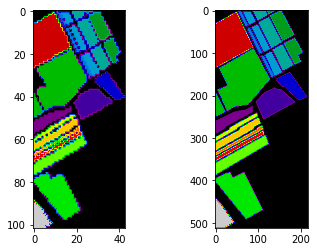

In [9]:
# 对比一下用5*5代替1*1的情况下两种标签方式的图像
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2)
ax[0].imshow(Y_data.reshape(102, 43), cmap='nipy_spectral')
ax[1].imshow(data_gt, cmap='nipy_spectral')

In [17]:
Y_data = Y_data[:4205]
Y_data = Y_data.reshape(len(Y_data), 1)
# fig, ax = plt.subplots(1, 2)
# ax[0].imshow(Y_data.reshape(100, 42), cmap='nipy_spectral')
# ax[1].imshow(data_gt, cmap='nipy_spectral')

In [16]:
# to_categorical就是将类别向量转换为二进制（只有0和1）的矩阵类型表示。其表现为将原有的类别向量转换为 one-hot 模式
# 只能运行一次 ！！！
# Y_data = Y_data[:4205]
# from tensorflow.keras.utils import to_categorical
# Y_data = to_categorical(Y_data)
# type(Y_data)

In [18]:
print(X_data.shape)
print(Y_data.shape)

(4205, 5, 5, 204)
(4205, 1)


In [19]:
from sklearn.model_selection import train_test_split
(Xtrain, Xtest, Ytrain, Ytest) = train_test_split(X_data, Y_data, test_size=0.6)
Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape

((1682, 5, 5, 204), (2523, 5, 5, 204), (1682, 1), (2523, 1))

In [21]:
batchsz = 64

In [22]:
# 创建dataset
db = tf.data.Dataset.from_tensor_slices((Xtrain,Ytrain))  # 训练集合标签！
db = db.shuffle(4205).batch(batchsz).repeat()

db_test = tf.data.Dataset.from_tensor_slices((Xtest,Ytest))
db_test = db_test.batch(batchsz)
db

<RepeatDataset shapes: ((None, 5, 5, 204), (None, 1)), types: (tf.float64, tf.uint8)>

In [23]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(256, (3, 3), input_shape=(5,5,204), activation='relu', padding='same'))
print("orgin shape", model.output.shape)
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
print("afte MaxPool2D", model.output_shape)
# model.add(tf.keras.layers.MaxPool2D(3, 3))
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
print("afte MaxPool2D", model.output_shape)
# model.add(tf.keras.layers.MaxPool2D(5, 5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(17, activation='softmax', name='Salinas_Output'))

orgin shape (None, 5, 5, 256)
afte MaxPool2D (None, 5, 5, 256)
afte MaxPool2D (None, 3, 3, 512)


In [24]:
# model.summary()

In [25]:
# optimizer =tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08) 可以自定义优化器

In [26]:
model.compile(optimizer=optimizers.Adam(lr = 0.01),  # 优化器的选择
             loss='sparse_categorical_crossentropy',
              metrics=['acc']
             )

In [27]:
batchsz = 64

In [28]:
history = model.fit(db,
                    batch_size=batchsz, 
                    steps_per_epoch=65,
                    epochs=50, 
                    validation_data=db_test
                    )

Epoch 1/50
65/65 [==============================] - 1s 15ms/step - loss: 51.2474 - acc: 0.4201 - val_loss: 1.9600 - val_acc: 0.5065
Epoch 2/50
65/65 [==============================] - 1s 11ms/step - loss: 1.7804 - acc: 0.4975 - val_loss: 1.5488 - val_acc: 0.5065
Epoch 3/50
65/65 [==============================] - 1s 12ms/step - loss: 1.3530 - acc: 0.5554 - val_loss: 1.2379 - val_acc: 0.5854
Epoch 4/50
65/65 [==============================] - 1s 11ms/step - loss: 1.2042 - acc: 0.5983 - val_loss: 1.2341 - val_acc: 0.5842
Epoch 5/50
65/65 [==============================] - 1s 11ms/step - loss: 1.1857 - acc: 0.5995 - val_loss: 1.1052 - val_acc: 0.6132
Epoch 6/50
65/65 [==============================] - 1s 11ms/step - loss: 1.1813 - acc: 0.6069 - val_loss: 1.1213 - val_acc: 0.6266
Epoch 7/50
65/65 [==============================] - 1s 11ms/step - loss: 1.0842 - acc: 0.6256 - val_loss: 1.0636 - val_acc: 0.6472
Epoch 8/50
65/65 [==============================] - 1s 11ms/step - loss: 1.0816 - 

In [29]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

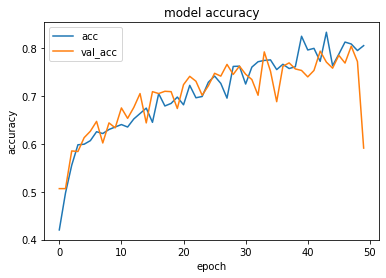

In [30]:
#  观察图像，发现优化的一个方向在提高训练精度，训练数据精度不高
#  观察图像，发现优化的存在过拟合，测试和训练存在差距
# plt.plot(history.epoch, history.history.get('acc'), label='acc')
# plt.plot(history.epoch, history.history.get('val_acc'), label='val_acc')

plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='best')
plt.show()

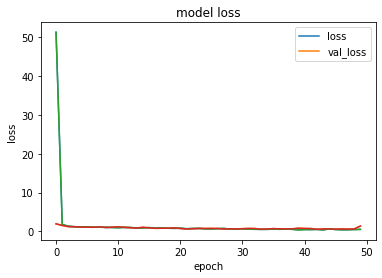

In [31]:
plt.plot(history.epoch, history.history.get('loss'), label='loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='val_loss')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='best')
plt.show()